In [11]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo, plot_importance_scores


In [2]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : isol.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : isol.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : isol.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [4]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [5]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [6]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))


In [7]:
#Load Predictor
predictor_path = '../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')

predictor.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 205, 4, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 198, 1, 96)   3168        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 99, 1, 96)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
#APARENT parameters
seq_input_shape = (1, 205, 4)
lib_input_shape = (13,)
distal_pas_shape = (1,)
num_outputs_iso = 1
num_outputs_cut = 206

#Shared model definition
layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu')
layer_1_pool = MaxPooling2D(pool_size=(2, 1))
layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu')
layer_dense = Dense(256, activation='relu')
layer_drop = Dropout(0.2)

def shared_model(seq_input, distal_pas_input) :
    return layer_drop(
        layer_dense(
            Concatenate()([
                Flatten()(
                    layer_2(
                        layer_1_pool(
                            layer_1(
                                seq_input
                            )
                        )
                    )
                ),
                distal_pas_input
            ])
        )
    )

#Inputs
seq_input = Input(shape=seq_input_shape)
lib_input = Input(shape=lib_input_shape)
distal_pas_input = Input(shape=distal_pas_shape)

permute_layer = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))

plasmid_out_shared = Concatenate()([shared_model(permute_layer(seq_input), distal_pas_input), lib_input])

plasmid_out_cut = Dense(num_outputs_cut, activation='softmax', kernel_initializer='zeros')(plasmid_out_shared)
plasmid_out_iso = Dense(num_outputs_iso, activation='linear', kernel_initializer='zeros')(plasmid_out_shared)

predictor_temp = Model(
    inputs=[
        seq_input,
        lib_input,
        distal_pas_input
    ],
    outputs=[
        plasmid_out_iso,
        plasmid_out_cut
    ]
)

predictor_temp.load_weights('../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5')

predictor = Model(
    inputs=predictor_temp.inputs,
    outputs=[
        predictor_temp.outputs[0]
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


In [9]:
#Overwrite x_test with variant sequences

encoder = isol.OneHotEncoder(205)

seqs_ref = [
    'GTTCCTCCTGCCCGCTGGGCCTCCCAACGGGCCCTCCTCCCCTCCTTGCACCGGCCCTTCCTGGTCTTTGAATAAAGTCTGAGTGGGCAGCAGCCTGTGTGTGCCTGGGTTCTCTCTATCCCGGAATGTGCCAACAATGGAGGTGTTTACCTGTCTCAGACCAAGGACCTCTCTGCAGCTGCATGGGGCTGGGGAGGGAGAACTG', #HBA2 104G>T HGMD
    'CTCATATTCTGGGCTCCTGGAACCAATCCCGTGAAAGAATTATTTTTGTGTTTCTAAAACTATGGTTCCCAATAAAAGTGACTCTCAGCGAGCCTCAATGCTCCCAGTGCTATTCATGGGCAGCTCTCTGGGCTCAGGAAGAGCCAGTAATACTACTGGATAAAGAAGACTTAAGAATCCACCACCTGGTGCACGCTGGTAGTCC', #F2 108C>T HGMD
]

seqs_var = [
    'GTTCCTCCTGCCCGCTGGGCCTCCCAACGGGCCCTCCTCCCCTCCTTGCACCGGCCCTTCCTGGTCTTTGAATAAAGTCTGAGTGTGCAGCAGCCTGTGTGTGCCTGGGTTCTCTCTATCCCGGAATGTGCCAACAATGGAGGTGTTTACCTGTCTCAGACCAAGGACCTCTCTGCAGCTGCATGGGGCTGGGGAGGGAGAACTG', #HBA2 104G>T HGMD
    'CTCATATTCTGGGCTCCTGGAACCAATCCCGTGAAAGAATTATTTTTGTGTTTCTAAAACTATGGTTCCCAATAAAAGTGACTCTCAGCGAGCCTCAATGTTCCCAGTGCTATTCATGGGCAGCTCTCTGGGCTCAGGAAGAGCCAGTAATACTACTGGATAAAGAAGACTTAAGAATCCACCACCTGGTGCACGCTGGTAGTCC', #F2 108C>T HGMD
]

n_variants = len(seqs_var)

while len(seqs_ref) % 32 != 0 :
    seqs_ref.append(seqs_ref[-1])

while len(seqs_var) % 32 != 0 :
    seqs_var.append(seqs_var[-1])

x_ref = np.concatenate([encoder.encode(seqs_ref[i])[None, None, ...] for i in range(len(seqs_ref))], axis=0)
x_var = np.concatenate([encoder.encode(seqs_var[i])[None, None, ...] for i in range(len(seqs_var))], axis=0)


In [10]:
#Feature substitution, sequences

def run_perturb(x_test) :

    aparent_l_test = np.zeros((x_test.shape[0], 13))
    aparent_l_test[:, 4] = 1.

    aparent_d_test = np.ones((x_test.shape[0], 1))

    perturb_scores_test = np.zeros(x_test.shape)

    y_hat_ref = predictor.predict([x_test, aparent_l_test, aparent_d_test], batch_size=32, verbose=True)[:, 0]

    aparent_l_var = np.zeros((x_test.shape[2] * x_test.shape[3], 13))
    aparent_l_var[:, 4] = 1.

    aparent_d_var = np.ones((x_test.shape[2] * x_test.shape[3], 1))

    for data_ix in range(x_test.shape[0]) :

        if data_ix % 100 == 0 :
            print("Processing example " + str(data_ix) + "...")

        x = x_test[data_ix, :, :, :]
        x_var = np.zeros((x.shape[1] * x.shape[2], 1, x.shape[1], x.shape[2]))

        x_var[:, :, :, :] = x[:, :, :]

        for j in range(x_test.shape[2]) :
            for k in range(x_test.shape[3]) :
                x_var[j * x_test.shape[3] + k, 0, j, :] = 0.
                x_var[j * x_test.shape[3] + k, 0, j, k] = 1.

        y_hat_var = predictor.predict([x_var, aparent_l_var, aparent_d_var], batch_size=32)[:, 0]

        for j in range(x_test.shape[2]) :
            for k in range(x_test.shape[3]) :
                perturb_scores_test[data_ix, 0, j, k] = y_hat_var[j * x_test.shape[3] + k] - y_hat_ref[data_ix]
        
    importance_scores_test = np.zeros(perturb_scores_test.shape)

    importance_scores_test[:, :, :, :] = np.tile(np.expand_dims(np.mean(perturb_scores_test[:, :, :, :], axis=-1), axis=-1), (1, 1, 1, 4))
    importance_scores_test_signed = np.copy(importance_scores_test * x_test)
    importance_scores_test = np.abs(importance_scores_test * x_test)
    
    return importance_scores_test

importance_scores_ref = run_perturb(x_ref)
importance_scores_var = run_perturb(x_var)


32/32 [==============================] - 3s 92ms/step
Processing example 0...
32/32 [==============================] - 0s 68us/step
Processing example 0...


Variant 0:
- Ref -


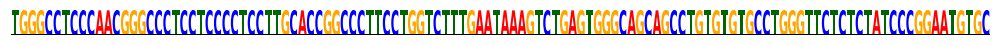

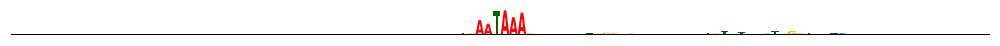

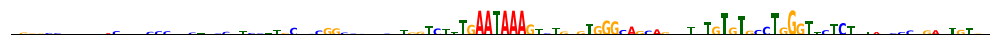

- Var -


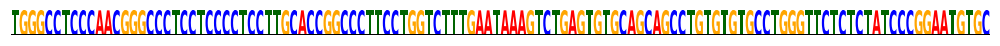

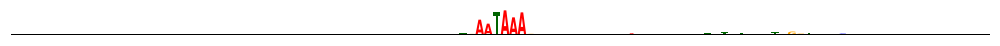

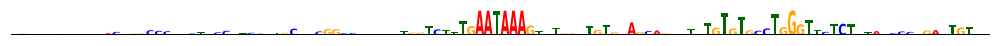

Variant 1:
- Ref -


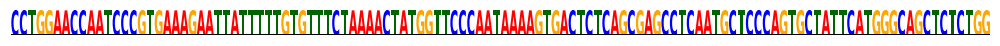

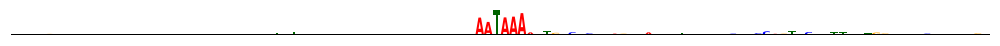

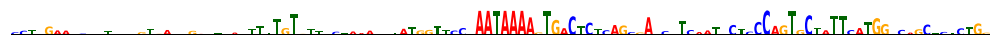

- Var -


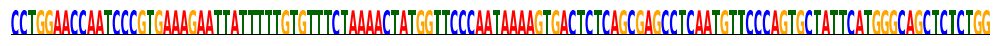

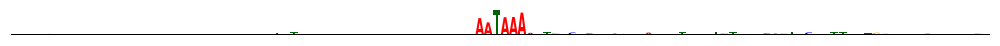

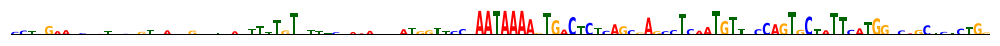

In [17]:
#Visualize a few perturbations

model_name = 'perturbation'

sequence_template = 'N' * 205

save_figs = True

for plot_i in range(0, n_variants) :
    
    print("Variant " + str(plot_i) + ":")
    
    print("- Ref -")
    
    plot_dna_logo(x_ref[plot_i, 0, 15:15+116, :], sequence_template=sequence_template, figsize=(14, 0.75), plot_start=0, plot_end=116, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_clinvar_snv_ix_" + str(plot_i) + "_ref_orig_sequence")
    plot_importance_scores(importance_scores_ref[plot_i, 0, 15:15+116, :].T, encoder.decode(x_ref[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_clinvar_snv_ix_" + str(plot_i) + "_ref_scores")
    plot_importance_scores(importance_scores_ref[plot_i, 0, 15:15+116, :].T, encoder.decode(x_ref[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=np.quantile(importance_scores_ref[plot_i, 0, 15:15+116, :], q=0.987), sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_clinvar_snv_ix_" + str(plot_i) + "_ref_scores_qt_987")

    print("- Var -")
    
    plot_dna_logo(x_var[plot_i, 0, 15:15+116, :], sequence_template=sequence_template, figsize=(14, 0.75), plot_start=0, plot_end=116, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_clinvar_snv_ix_" + str(plot_i) + "_var_orig_sequence")
    plot_importance_scores(importance_scores_var[plot_i, 0, 15:15+116, :].T, encoder.decode(x_var[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_clinvar_snv_ix_" + str(plot_i) + "_var_scores")
    plot_importance_scores(importance_scores_var[plot_i, 0, 15:15+116, :].T, encoder.decode(x_var[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=np.quantile(importance_scores_var[plot_i, 0, 15:15+116, :], q=0.987), sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_clinvar_snv_ix_" + str(plot_i) + "_var_scores_qt_987")


In [18]:
#Overwrite x_test with variant sequences

encoder = isol.OneHotEncoder(205)

seqs_ref = [
    'GGAAACTGTATTAATCTTATTCTATCCTCTTTTCTTTCTTTTTGTTGAACATATTCATTGTTTGTTTATTAATAAATTACCATTCAGTTTGAATGAGACCTATATGTCTGGATACTTTAATAGAGCTTTAATTATTACGAAAAAAGATTTCAGAGATAAAACACTAGAAGTTACCTATTCTCCACCTAAATCTCTGAAAAATGGA', #FOXC1
    'CATTTTCACCCCACCCTTCCCCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTGCAATGAGTGTGGGCTGGGGGG', #TP53
    'AGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTGGGTGCCCACAGGTGCCAACGC', #INS
    'AGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTGGGTGCCCACAGGTGCCAACGC', #INS
    'AGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTGGGTGCCCACAGGTGCCAACGC', #INS
    'CTTTGTTCCCTAAGTCCAACTACTAAACTGGGGGATATTATGAAGGGCCTTGAGCATCTGGATTCTGCCTAATAAAAAACATTTATTTTCATTGCAATGATGTATTTAAATTATTTCTGAATATTTTACTAAAAAGGGAATGTGGGAGGTCAGTGCATTTAAAACATAAAGAAATGAAGAGCTAGTTCAAACCTTGGGAAAATAC', #HBB
    'AGTGTGCAAGGGCAGTGAAGACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCTTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGGGTAATGATAGTATCTACCTCC', #BRCA1
]

seqs_var = [
    'GGAAACTGTATTAATCTTATTCTATCCTCTTTTCTTTCTTTTTGTTGAACATATTCATTGTTTGTTTATTAATAAATTACCATTCAGTTTGAATGAGACCTATATGACTGGATACTTTAATAGAGCTTTAATTATTACGAAAAAAGATTTCAGAGATAAAACACTAGAAGTTACCTATTCTCCACCTAAATCTCTGAAAAATGGA', #FOXC1 Knock out CstF
    'CATTTTCACCCCACCCTTCCCCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGGCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTGCAATGAGTGTGGGCTGGGGGG', #TP53 Knock out CstF + structure
    'AGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGGCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTGGGTGCCCACAGGTGCCAACGC', #INS Knock out CstF
    'AGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGAGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTGGGTGCCCACAGGTGCCAACGC', #INS Knock out G-rich motif
    'AGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGATAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTGGGTGCCCACAGGTGCCAACGC', #INS Knock out upstream SRSF10 motif (AG-repeat)
    'CTTTGTTCCCTAAGTCCAACTACTAAACTGGGGGATATTATGAAGGGCCTTGAGCATCTGGATTCTGCCTAATAAAAAACATTTATTTTCATTGCAATGATGTATTTAAATTAGTTCTGAATATTTTACTAAAAAGGGAATGTGGGAGGTCAGTGCATTTAAAACATAAAGAAATGAAGAGCTAGTTCAAACCTTGGGAAAATAC', #HBB Knock out DSE T-rich motif
    'AGTGTGCAAGGGCAGTGAAGACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCCTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGGGTAATGATAGTATCTACCTCC', #BRCA1 Knock out DSE T-rich motif
]

n_variants = len(seqs_var)

while len(seqs_ref) % 32 != 0 :
    seqs_ref.append(seqs_ref[-1])

while len(seqs_var) % 32 != 0 :
    seqs_var.append(seqs_var[-1])

x_ref = np.concatenate([encoder.encode(seqs_ref[i])[None, None, ...] for i in range(len(seqs_ref))], axis=0)
x_var = np.concatenate([encoder.encode(seqs_var[i])[None, None, ...] for i in range(len(seqs_var))], axis=0)


In [19]:

importance_scores_ref = run_perturb(x_ref)
importance_scores_var = run_perturb(x_var)


32/32 [==============================] - 0s 110us/step
Processing example 0...
32/32 [==============================] - 0s 81us/step
Processing example 0...


Variant 0:
- Ref -


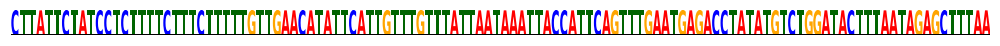

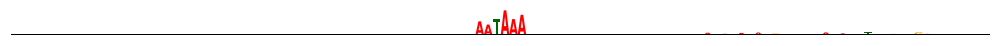

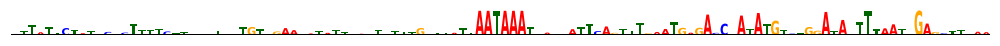

- Var -


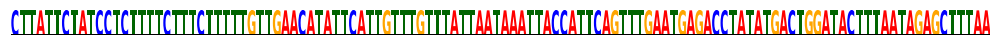

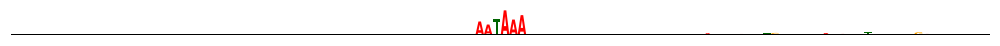

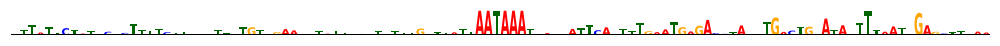

Variant 1:
- Ref -


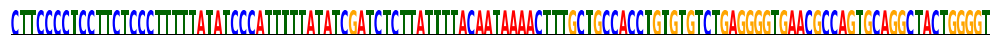

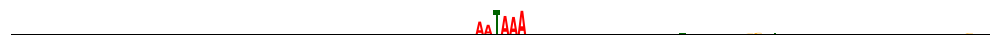

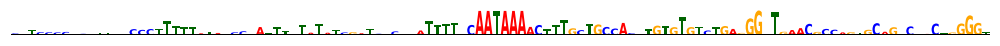

- Var -


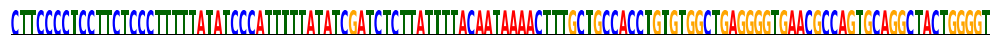

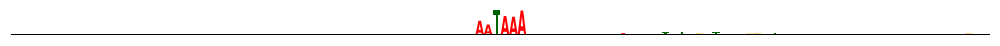

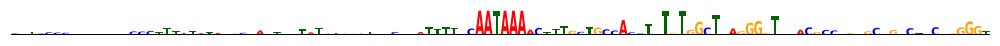

Variant 2:
- Ref -


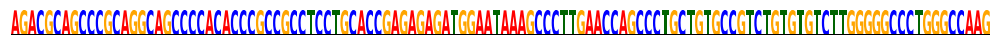

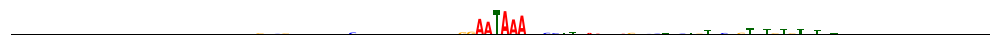

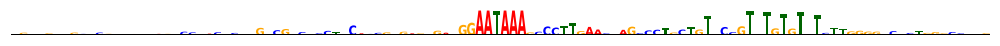

- Var -


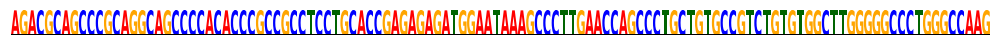

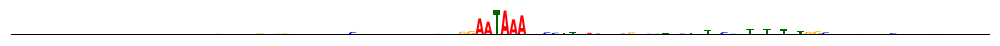

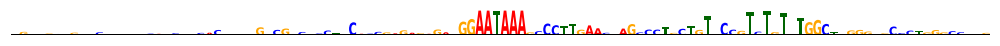

Variant 3:
- Ref -


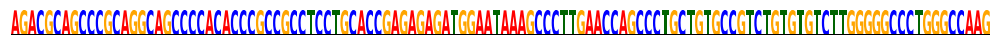

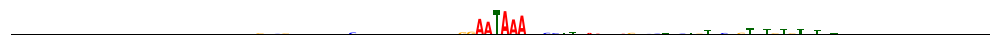

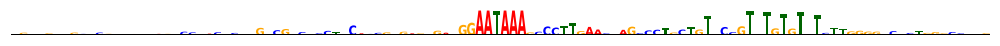

- Var -


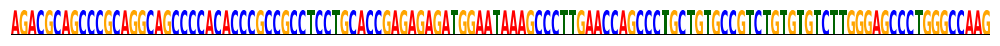

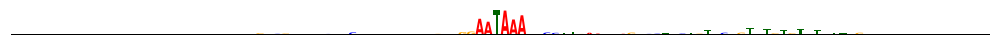

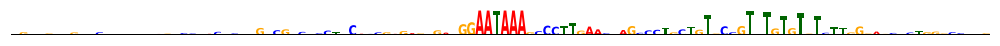

Variant 4:
- Ref -


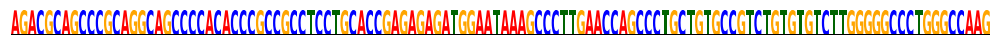

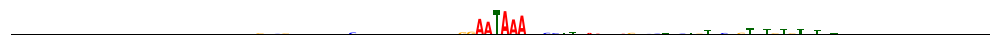

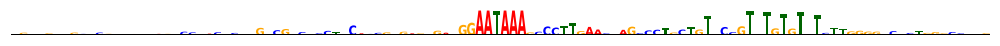

- Var -


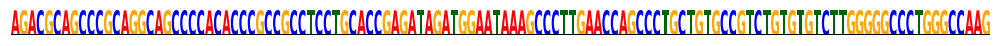

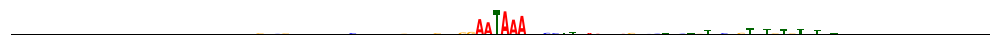

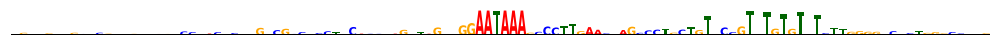

Variant 5:
- Ref -


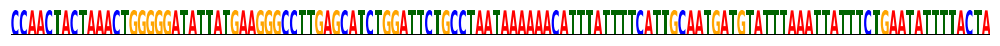

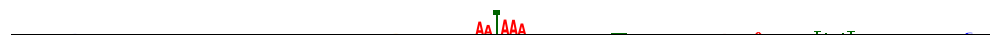

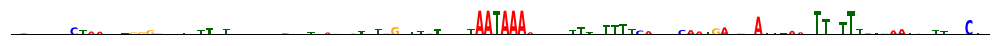

- Var -


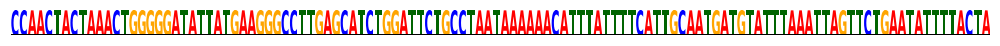

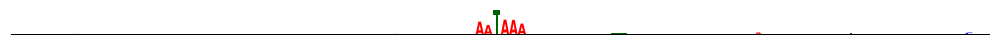

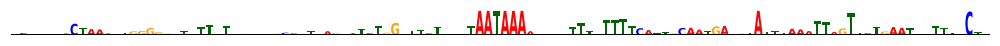

Variant 6:
- Ref -


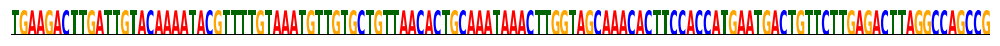

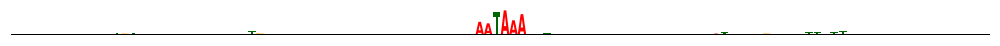

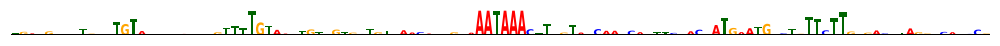

- Var -


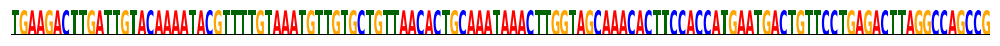

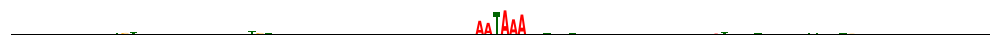

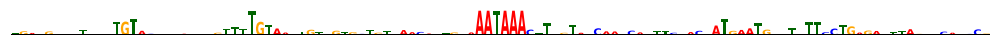

In [20]:
#Visualize a few perturbations

model_name = 'perturbation'

sequence_template = 'N' * 205

save_figs = True

for plot_i in range(0, n_variants) :
    
    print("Variant " + str(plot_i) + ":")
    
    print("- Ref -")
    
    plot_dna_logo(x_ref[plot_i, 0, 15:15+116, :], sequence_template=sequence_template, figsize=(14, 0.75), plot_start=0, plot_end=116, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_snv_ix_" + str(plot_i) + "_ref_orig_sequence")
    plot_importance_scores(importance_scores_ref[plot_i, 0, 15:15+116, :].T, encoder.decode(x_ref[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_snv_ix_" + str(plot_i) + "_ref_scores")
    plot_importance_scores(importance_scores_ref[plot_i, 0, 15:15+116, :].T, encoder.decode(x_ref[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=np.quantile(importance_scores_ref[plot_i, 0, 15:15+116, :], q=0.987), sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_snv_ix_" + str(plot_i) + "_ref_scores_qt_987")

    print("- Var -")
    
    plot_dna_logo(x_var[plot_i, 0, 15:15+116, :], sequence_template=sequence_template, figsize=(14, 0.75), plot_start=0, plot_end=116, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_snv_ix_" + str(plot_i) + "_var_orig_sequence")
    plot_importance_scores(importance_scores_var[plot_i, 0, 15:15+116, :].T, encoder.decode(x_var[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_snv_ix_" + str(plot_i) + "_var_scores")
    plot_importance_scores(importance_scores_var[plot_i, 0, 15:15+116, :].T, encoder.decode(x_var[plot_i, 0, 15:15+116, :]), figsize=(14, 0.75), score_clip=np.quantile(importance_scores_var[plot_i, 0, 15:15+116, :], q=0.987), sequence_template=sequence_template, plot_start=0, plot_end=116, save_figs=save_figs, fig_name=model_name + "_snv_ix_" + str(plot_i) + "_var_scores_qt_987")
